### 数据预处理与加载
#### 通用实现

Dataset继承类的实现

重要重载方法：

-  $__len__$
-  $__get_item__$

In [40]:

import torch
import os,glob
import random,csv
import time
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from torchvision import transforms
import visdom

class Pokemon(Dataset):
    def __init__(self,root,resize,mode):
        super(Pokemon, self).__init__()
        self.root = root
        self.resize = resize

        self.name2label = {} # "sq...":0  编码
        for name in sorted(os.listdir(os.path.join(root))):
            if not os.path.isdir(os.path.join(root,name)):
                continue

            # 按照来的先后顺序获得编码，借助len(self.name2label.keys())
            self.name2label[name] = len(self.name2label.keys())
        print(self.name2label)


        # image_path,label
        self.images, self.labels = self.load_csv("image.csv")

        #split dataset
        if mode=='train': #60%
            self.images = self.images[:int(0.6*len(self.images))]
            self.labels = self.labels[:int(0.6*len(self.labels))]

        elif mode =='val': #20%
            self.images = self.images[int(0.6 * len(self.images)):int(0.8*len(self.images))]
            self.labels = self.labels[int(0.6 * len(self.labels)):int(0.8*len(self.labels))]
        elif mode =='test': #20%
            self.images = self.images[int(0.8*len(self.images)):]
            self.labels = self.labels[int(0.8 * len(self.labels)):]

    def load_csv(self,filename):
        """
            将数据集的image_path——label对存储到csv文件中，并从csv文件加载
        """
        savepath = os.path.join(self.root, filename)
        if not os.path.exists(savepath):#路径不存在，即需要我们进行存储
            images =  []
            for name in self.name2label.keys():
                images += glob.glob(os.path.join(self.root,name,'*.png'))
                images += glob.glob(os.path.join(self.root,name,'*.jpg'))
                images += glob.glob(os.path.join(self.root, name, '*.gif'))

            # '../all/ai_pytorch/pokeman\\bulbasaur\\00000000.png'
            # print(len(images),images)

            random.shuffle(images)# shuffle

            with open(savepath,mode='w',newline='') as f:
                #写入csv文件，[img,label]
                writer = csv.writer(f)
                for img in images:
                    name = img.split(os.sep)[-2]
                    label = self.name2label[name]
                    writer.writerow([img,label])
                print('written into csv file: ',savepath)

        images,labels = [],[]
        with open(savepath) as f:
            #读取
            reader = csv.reader(f)
            for row in reader:
                img,label = row
                label = int(label)
                images.append(img)
                labels.append(label)
        assert  len(images) == len(labels)

        return images,labels



    def __len__(self):
        """
            返回数据集长度
        """
        return len(self.images)

    def denormalize(self,x_hat):
        mean = [0.485,0.456,0.406]
        std = [0.229,0.224,0.225]

        #x_hat = (x - mean)/std
        #x = x_hat*std+mean
        #x:[c,h,w]
        mean = torch.tensor(mean).unsqueeze(1).unsqueeze(1)
        std = torch.tensor(std).unsqueeze(1).unsqueeze(1)

        x = x_hat*std+mean

        return x

    def __getitem__(self, idx):
        """
               # idx~[0-len(images)]
              返回 self.images,self.labels
        """
     

        img,label = self.images[idx],self.labels[idx]
        
        
        # transfrom 进行图像的预处理，包括裁剪 数据增强 变为tensor 规范化
        tf = transforms.Compose(
            [lambda  x:Image.open(x).convert('RGB'),#string path=>image data

             transforms.Resize((int(self.resize*1.25),int(self.resize*1.25))),

             transforms.RandomRotation(15),##太大很难收敛
             transforms.CenterCrop(self.resize), #中心裁剪：在旋转之后空白的地方会补充黑色部分，使用中心裁剪将区域对准
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),#该值是ImageNet的计算值，可以借鉴用于别的数据集

             ]
        )

        img = tf(img)
        label = torch.tensor(label)

        return img,label


In [51]:
# -*- coding:UTF-8 -*-

# author:34860
# contact: test@test.com
# datetime:2022-11-24 16:04
# software: PyCharm

"""
文件说明：
    
"""
import torch
import os,glob
import random,csv
import time
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from torchvision import transforms

class Pokemen(Dataset):
    def __init__(self,root,resize,mode):
        '''

        :param root: 数据集根目录；
                    这次的存储形式是根目录下有文件夹，每个文件夹下是数据集图片，文件夹名称是对应的类别
        :param resize:
        :param mode: train\test\val
        '''
        super(Pokemen, self).__init__()
        self.root = root
        self.resize = resize

        self.name2label = {}# 存储name对应编码的字典
        #遍历根目录下文件夹名称
        for name in sorted(os.listdir(os.path.join(root))):
            if not os.path.isdir(os.path.join(root,name)):
                # not a dir
                continue
            # 按照先后顺序获得编码
            self.name2label[name] = len(self.name2label.keys())
        print(self.name2label)

        # 从csv文件中读取 image_path-label；
        # load_csv方法实现将数据集条目：image_path-label 整理到csv文件中
        self.images,self.labels = self.load_csv("image.csv")

        #划分数据集
        if mode == 'train': #60%
            self.images = self.images[:int(0.6*len(self.images))]
            self.labels = self.labels[:int(0.6*len(self.labels))]
        elif mode == 'val': #20%
            self.images = self.images[int(0.6 * len(self.images)):int(0.8*len(self.images))]
            self.labels = self.labels[int(0.6 * len(self.labels)):int(0.8*len(self.labels))]
        elif mode == 'test':
            self.images = self.images[int(0.8 * len(self.images)):]
            self.labels = self.labels[int(0.8 * len(self.labels)):]

    def load_csv(self,filename):
        '''
        将数据集的image_path-label存储到csv文件中，并从csv文件加载
        :param filename: 存储csv的文件路径
        :return: images,labels==> images_path,labels
        '''
        savepath = os.path.join(self.root,filename)
        if not os.path.exists(savepath):
            images = []
            for name in self.name2label.keys():
                #获取对应文件夹下的图片文件,存储到list(images)内
                images += glob.glob(os.path.join(self.root,name,'*.png'))
                images += glob.glob(os.path.join(self.root, name, '*.jpg'))
                images += glob.glob(os.path.join(self.root, name, '*.gif'))
            #print(images)
            #'./pokeman/squirtle\\00000073.png'
            random.shuffle(images) #shuffle
            #写入csv
            with open(savepath,mode='w',newline='') as f:
                writer = csv.writer(f)
                for img in images:
                    name = img.split(os.sep)[-2]
                    label = self.name2label[name]
                    writer.writerow([img,label])
                print('written into csv file:',savepath)
        
        #从csv文件读取
        images,labels = [],[]
        with open(savepath) as f:
            reader = csv.reader(f)
            for row in reader:
                img,label = row
                label = int(label)
                images.append(img)
                labels.append(label)
        assert  len(images) == len(labels)
        
        return  images,labels
    
    def __len__(self):
        '''
        :return: 数据集长度
        '''
        return len(self.images)
    
    def __getitem__(self, item):
        '''
        
        :param item: range in [0,len(images)]
        :return: self.images,self.labels
        '''
        
        img,label = self.images[item],self.labels[item]
        
        tf = transforms.Compose(
            [lambda x:Image.open(x).convert('RGB'), # open image and convert to RGB
             transforms.Resize((int(self.resize*1.25),int(self.resize*1.25))),
             transforms.RandomRotation(15),
             transforms.CenterCrop(self.resize),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),#values computed from ImageNet，we could use it in other dataset   
             
             ]  
        )
        
        img = tf(img)
        label = torch.tensor(label)
        return img,label
db = Pokemon('./pokeman', 224, 'train')
x,y = next(iter(db))
print(x.shape,y.shape)

{'.ipynb_checkpoints': 0, 'bulbasaur': 1, 'charmander': 2, 'mewtwo': 3, 'pikachu': 4, 'squirtle': 5}
written into csv file:  ./pokeman\image.csv
torch.Size([3, 224, 224]) torch.Size([])


数据集加载：DataLoader



In [41]:
import  visdom
import  torchvision
import os
viz = visdom.Visdom()
db = Pokemon('./pokeman', 224, 'train')
x,y = next(iter(db))
print(x.shape,y.shape)
viz.image(db.denormalize(x), win='sample_x', opts=dict(title='sample_x'))
loader = DataLoader(db,batch_size=32,shuffle=True)
for x,y in loader:
        viz.images(db.denormalize(x),nrow=8,win='batch',opts=dict(title='batch'))
        viz.text(str(y.numpy()),win='label',opts=dict(title='batch-y'))
        time.sleep(10)

Setting up a new session...


{'.ipynb_checkpoints': 0, 'bulbasaur': 1, 'charmander': 2, 'mewtwo': 3, 'pikachu': 4, 'squirtle': 5}
torch.Size([3, 224, 224]) torch.Size([])


E:\APP\Anaconda\envs\Fpytorch\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [3]:
! python -m visdom.server

^C


#### 特殊便捷方式数据集加载

使用函数datasets.ImageFolder
使用场景：适用于将数据集分文件夹存储，文件夹名称为对应的label

In [ ]:
    tf  = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor()
    ])
    ##适用于将数据集分文件夹存储，文件夹名称为对应的label
    db = torchvision.datasets.ImageFolder(root='../all/ai_pytorch/pokeman',transform=tf)
    loader = DataLoader(db,batch_size=32,shuffle=True)
    print(db.class_to_idx)

### 网络创建


In [ ]:
#Resnet.py
import torch
from  torch import  nn
from torch.nn import functional as F
class ResBlk(nn.Module):
    """
    resnet block
    """
    def __init__(self,ch_in,ch_out,stride=1):
        """

        :param ch_in:[b,ch,h,w]
        :param ch_out:
        """
        super(ResBlk, self).__init__()
        self.conv1 = nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=stride,padding=1)
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(ch_out)

        self.extra = nn.Sequential()

        if ch_out!=ch_in:
            self.extra = nn.Sequential(
                nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=stride),
                nn.BatchNorm2d(ch_out)
            )

    def forward(self,x):
        out =  F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        ##short cut
        #extra module:[b,ch_in,h,w]=>[b,ch_out,h,w]
        #element-wise add
        #
        out = self.extra(x) +out
        return out


class ResNet18(nn.Module):

    def __init__(self,num_class):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=3,padding=0),
            nn.BatchNorm2d(16)
        )
        #followed 4 blocks
        #[b,16,h,w]=>[b,32,h,w]
        self.blk1 =ResBlk(16,32,stride=3)
        # [b,32,h,w]=>[b,64,h,w]
        self.blk2 = ResBlk(32,64,stride=3)
        #[b,64,h,w]=>[b,128,h,w]
        self.blk3 = ResBlk(64,128,stride=2)
        # [b,128,h,w]=>[b,256,h,w]
        self.blk4 = ResBlk(128,256,stride=2)
        self.flatten = nn.Flatten()
        self.outlayer = nn.Linear(256*3*3,num_class)

    def forward(self,x):
        """

        :param x:
        :return:
        """
        x = F.relu(self.conv1(x))
        #[b,64,h,w]=>[b,1024,h,w]
        x = self.blk1(x)
        x = self.blk2(x)
        x = self.blk3(x)
        x = self.blk4(x)
        print("after conv:",x.shape)
        # x = F.adaptive_max_pool2d(x,[1,1])
        # print("after pool,",x.shape)
        x = self.flatten(x)
        x = self.outlayer(x)

        return x


def main():
    blk = ResBlk(64,128)
    tmp = torch.rand(2,64,224,224)
    out = blk(tmp)
    print('block',out.shape)


    x  = torch.rand(2,3,224,224)
    model = ResNet18(5)
    out = model(x)
    print(out.shape)

    p = sum(map(lambda  p:p.numel(),model.parameters()))
    print('parameters size:',p)
    
if __name__ == '__main__':
    main()


### Train and test

In [ ]:
for epoch in range(epoch):
    train(train_db)
    if epoch%10==0:
        val_acc = evaluate(val_db)
        
        if val_loss is the best:
            save_ckpt()
        if out_of_patience():
            break

load_ckpt()# checkpoint model
test_acc = evaluate(test_db)

In [ ]:
#train_scratch.py
import  torch

from torch import optim,nn
import  visdom

import torchvision
from torch.utils.data import DataLoader

from pokeman import Pokemon
from Resnet import ResNet18

batchsz = 32
lr = 1e-2
epochs = 10

device = torch.device('cuda')
torch.manual_seed(1234)##随机种子


train_db = Pokemon('pokeman',224,mode='train')
val_db = Pokemon('pokeman',224,mode='val')
test_db = Pokemon('pokeman',224,mode='test')
train_loader = DataLoader(train_db,batch_size=batchsz,shuffle=True,num_workers=4)
val_loader = DataLoader(val_db,batch_size=batchsz,shuffle=True,num_workers=2)
test_loader = DataLoader(test_db,batch_size=batchsz,shuffle=True,num_workers=2)

viz = visdom.Visdom()

def evaluate(model,loader):
    correct = 0
    total = len(loader.dataset)
    for x,y in loader:
        x,y = x.to(device),y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
        correct += torch.eq(pred,y).sum().float().item()
    return correct/total


def main():
    model = ResNet18(5).to(device)
    optimizer = optim.Adam(model.parameters(),lr=lr)
    criteon = nn.CrossEntropyLoss()

    best_acc,best_epoch=0,0
    viz.line([0],[-1],win='loss',opts=dict(title='loss'))
    viz.line([0],[-1],win='val_acc',opts=dict(title='val_acc'))
    global_step=0
    for epoch in range(epochs):
        for step,(img,label) in enumerate(train_loader):

            # x:[b,3,224,224], y:[5]
            img,label = img.to(device),label.to(device)

            logits = model(img)
            loss = criteon(logits,label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            viz.line([loss.item()], [global_step], win='loss', update='append')
            global_step+=1

        if epoch%1 ==0:
            val_acc = evaluate(model,val_loader)
            if val_acc>best_acc:
                best_epoch = epoch
                best_acc = val_acc

                torch.save(model.state_dict(),'best.mdl')
            viz.line([val_acc], [epoch], win='val_acc', update='append')
    print('best acc:',best_acc,'best epoch',best_epoch)

    model.load_state_dict(torch.load('best.mdl'))
    print('loaded from checkpoint!')

    test_acc = evaluate(model,test_loader)
    print('test acc',test_acc)


if __name__ == '__main__':
    main()

best acc: 0.8583690987124464 best epoch 5

test acc 0.8497854077253219

### 迁移学习
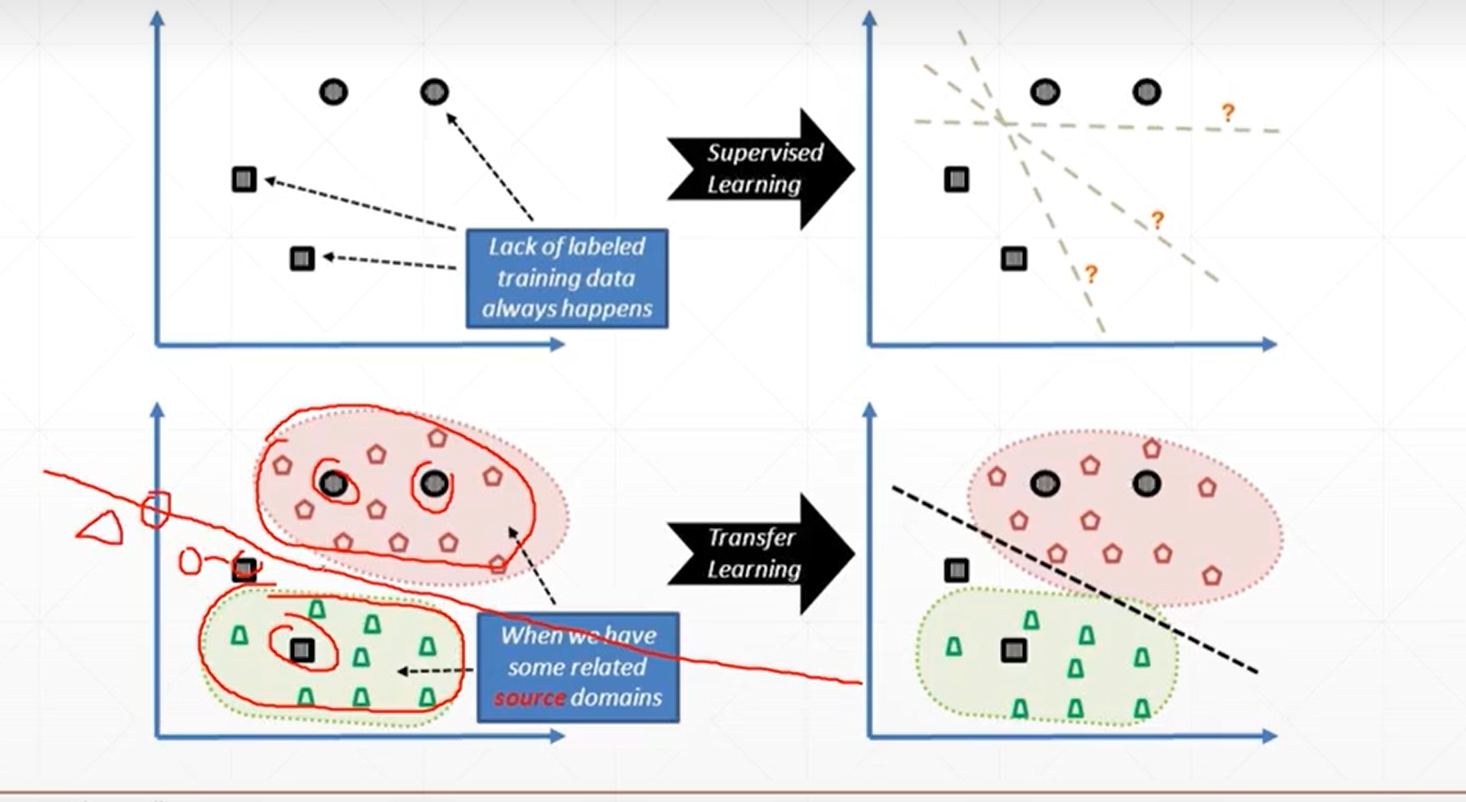

In [ ]:
import  torch

from torch import optim,nn
import  visdom

import torchvision
from torch.utils.data import DataLoader

from pokeman import Pokemon
from torchvision.models import resnet18 ##从网络获取模型

batchsz = 32
lr = 1e-2
epochs = 10

device = torch.device('cuda')
torch.manual_seed(1234)##随机种子


train_db = Pokemon('pokeman',224,mode='train')
val_db = Pokemon('pokeman',224,mode='val')
test_db = Pokemon('pokeman',224,mode='test')
train_loader = DataLoader(train_db,batch_size=batchsz,shuffle=True,num_workers=4)
val_loader = DataLoader(val_db,batch_size=batchsz,shuffle=True,num_workers=2)
test_loader = DataLoader(test_db,batch_size=batchsz,shuffle=True,num_workers=2)

viz = visdom.Visdom()

def evaluate(model,loader):
    correct = 0
    total = len(loader.dataset)
    for x,y in loader:
        x,y = x.to(device),y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
        correct = torch.eq(pred,y).sum().float().item()
    return correct/total


def main():
    # model = ResNet18(5).to(device)
    #-----------------------------------------------------------------------------------
    trained_model = resnet18(pretrained=True)
                #*用于迭代取出list中的内容
    model = nn.Sequential(*list(trained_model.children())[:-1],#[b,512,1,1]
                          nn.Flatten(),#[b,512,1,1]=>[b,512]
                          nn.Linear(512,5)
                          ).to(device)
    # x = torch.rand(2,3,224,224)
    # print(model(x).shape)
    #---------------------------------------------------------------------------------------
    optimizer = optim.Adam(model.parameters(),lr=lr)
    criteon = nn.CrossEntropyLoss()

    best_acc,best_epoch=0,0
    viz.line([0],[-1],win='loss',opts=dict(title='loss'))
    viz.line([0],[-1],win='val_acc',opts=dict(title='val_acc'))
    global_step=0
    for epoch in range(epochs):
        for step,(img,label) in enumerate(train_loader):

            # x:[b,3,224,224], y:[5]
            img,label = img.to(device),label.to(device)

            logits = model(img)
            loss = criteon(logits,label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            viz.line([loss.item()], [global_step], win='loss', update='append')
            global_step+=1

        if epoch%1 ==0:
            val_acc = evaluate(model,val_loader)
            if val_acc>best_acc:
                best_epoch = epoch
                best_acc = val_acc

                torch.save(model.state_dict(),'best.mdl')
            viz.line([val_acc], [epochs], win='val_acc', update='append')
    print('best acc:',best_acc,'best epoch',best_epoch)

    model.load_state_dict(torch.load('best.mdl'))
    print('loaded from checkpoint!')

    test_acc = evaluate(model,test_loader)
    print('test acc',test_acc)


if __name__ == '__main__':
    main()

best acc: 0.8412017167381974 best epoch 8

test acc 0.8025751072961373

视频里是说会比自己创建要好，但是....没有吧

In [ ]:
from torchvision.models import resnet18 ##从网络获取模型
trained_model = resnet18(pretrained=True)
                #*用于迭代取出list中的内容
model = nn.Sequential(*list(trained_model.children())[:-1],#[b,512,1,1]
                          nn.Flatten(),#[b,512,1,1]=>[b,512]
                          nn.Linear(512,5)
                          ).to(device)